In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import os


current_dir = os.getcwd()
phrase = "QuantitativeFinance"
target_path = current_dir.split(phrase)[0] + phrase
os.chdir(target_path)
print(os.getcwd())

np.set_printoptions(suppress=True)

from functions import generate_gbm_paths, generate_money_market_numeraire_paths

%load_ext autoreload
%autoreload 2


c:\OneDrive\Pulpit\QuantitativeFinance


#### **How can we switch measures, e.g. from real-world measure to risk-neutral measure?**

Asset prices dynamics in real world is assumed to follow process with drift that includes risk premium $\lambda$ and probabilities that come from real-world. To simplify calculations and get rid of calculation of each investor risk-preferences ($\lambda$), we need to swich measure of probability space from real-world to risk-neutral. On example of stock prices dynamics ($dS = \mu Sdt + \sigma SdW^{\mathbb{P}}$), there are a few methods that eliminates this:

1. **Black-Scholes-Merton formula derivation** <br>
By assuming that we can create a portfolio that perfectly hedges option value (delta-hedging) and his portfolio earns risk-free rate (so arbitrage is not possible) we get rid of $\mu$ term and uncertainty term, meaning that Wiener process from real-world probability space does not impact option price (check paper note called "Why can we price real-world option using risk neutral valuation? BSM formula derivation")

2. **Using martingale property** <br>
We want discounted stock price $\frac{S_T}{M_T}$ to be a martingale. We can deduct the dynamics of the process: $d\frac{S}{M} = (\mu - r)dt + \frac{1}{M}\sigma SdW^{\mathbb{P}}$. To get rid of $\mu$ and real-world measure we can use **measure transformation formula (Girsanov's theorem)**: $(\frac{\mu - r}{\sigma})dt + dW^{\mathbb{P}}(t) = dW^{\mathbb{Q}}(t)$. After substitutions we receive $d\frac{S}{M} = \frac{S}{M} \sigma dW^{\mathbb{Q}}(t)$ that is martingale and probability space is under risk-neutral measure (check paper note called "Switching from real-world measure to risk-neutral measure with use of martingale property")


#### **Some points regarding $\mathbb{P}$ and $\mathbb{Q}$ measures** (source: https://www.linkedin.com/pulse/from-real-risk-neutral-world-mastering-measure-changes-ochynski-zidce/)

- In probability theory and financial mathematics, a "measure" refers to a way of assigning probabilities to events
- The real-world measure, or measure $\mathbb{P}$, is based on historical data rather than the assumption of a risk-free rate
- In the real-world measure, through the discounting with appropriate rates, which include the risk premium, the discounting leads also to spot price and we have also a martingale process
- The assumption of different growth rates generates or creates different probabilities for the same stock prices between $\mathbb{P}$ and $\mathbb{Q}$ measures
- $\mathbb{Q}$ world is especially used for pricing derivatives and $\mathbb{P}$ world for analyzing past data and preparing basis for forecast, portfolio selection and allocation.
- A martingale is a stochastic process with zero drift, implying that the best prediction of a security's future price is its current price, given all available information. In this context, a measure refers to a probability distribution used to evaluate security prices and their expected values
- The **equivalent martingale measure**, also known as a risk-neutral measure, is a probability measure under which the discounted price process of a traded asset becomes a martingale
- Girsanov's theorem provides the mathematical foundation for changing probability measures, allowing us to adjust the drift of a stochastic process without altering its volatility
- The Real-World Probability Measure reflects the actual likelihood of events in the real-world, based on historical data and real economic conditions. Under $\mathbb{P}$, expected returns reflect both the actual drift (growth) of asset prices with included risk premiums that investors demand for bearing risk
- The Risk-Neutral Probability Measure is an artificial or adjusted probability measure used in pricing of derivatives. Under $\mathbb{Q}$ all assets are expected to grow at the risk-free rate, and investors are indifferent to risk
- The change of measure from $\mathbb{P}$ to $\mathbb{Q}$ involves adjusting the real-world probabilities of outcomes so that under $\mathbb{Q}$, the expected return of risky assets matches the risk-free rate. The adjustment of probabilities between one world and another can be performed using a **Radon-Nikodym derivative**. You can also adjust drift using **Girsanov Theorem**
- Price fluctuations still occur with the same frequency and size, but under $\mathbb{Q}$, the expected direction of movement is lower because there is no additional compensation for risk
- The fluctuations in asset prices (their magnitude) are consistent under both $\mathbb{P}$ and $\mathbb{Q}$ but the likelihood of various price movements is altered under $\mathbb{Q}$ to reflect the removal of the risk premium, adjusting the probabilities so that the expected return matches the risk-free rate
- Example: Volatility amounts to 20%, a risk free-rate is 2% and real-world expected return is 8%. Under real-world measure stock has volatility of 20% and the trend is 8%. Under risk-neutral measure volatility is also 20% but expected growth is 2%. Under P there is a higher probability that stock will rise compared to Q due to higher expected return. Conversely, the probability of stock price falling might increase under Q, reflecting a world where prices are expected to grow at the risk-free rate rather than a premium-adjusted rate
- Using risk-neutral probabilities allows us to price derivatives within a unified framework, assuming all investors are indifferent to risk, and only return that matters is the risk-free rate. This is a key result from **Girsanov’s Theorem**, which adjusts drift without altering volatility
- **Two worlds the same volatility but different trends and probabilities**


#### **Girsanov's theorem**

It allows us to move from the real-world measure (with drift $\mu$) to the risk-neutral measure (with drift $r$) by accounting for the market price of risk $\lambda$. The market price of risk $\lambda$ is defined as the excess return per unit of volatility: $\lambda = \frac{(\mu - r)}{\sigma }$. This transformation illustrates that the fundamental difference between the real-world and risk-neutral measures lies in the drift term. By applying the Girsanov theorem, we effectively transition between these measures, allowing us to price options in a consistent way, regardless of the drift under the real-world scenario. 

Girsanov's theorem describes how the dynamics of stochastic process change when the original measure is changed to an equivalent pobability measure.

Girsanov's theorem states that in the case of GBM:

$W_t^{\mathbb{Q}} = \frac{\mu - r}{\sigma}t + W_t^{\mathbb{P}}$




**Let's illustrate this**. Assume that we are in real-world measure and the price $S_t$ follows GBM with drift $\mu$: $dS_t = \mu S_tdt + \sigma S_tdW_t^{\mathbb{P}}$ and compare it to risk-neutral measure dynamics: $\mu$: $dS_t = \r S_tdt + \sigma S_tdW_t^{\mathbb{Q}}$


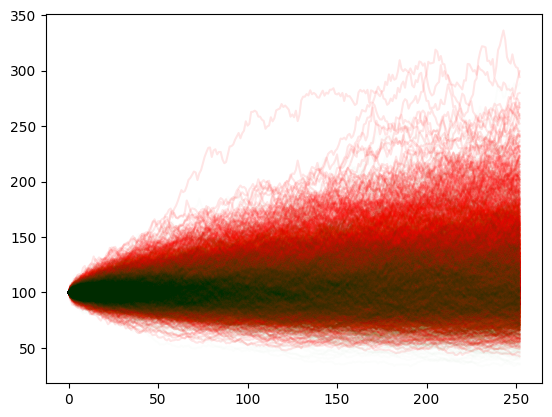

Mean price (expectation) at the end of the paths: 
 - under real world measure: 121.8838 
 - under risk neutral measure: 107.7197


In [45]:
s0 = 100
mu = 0.2
r = 0.07
sigma = 0.3
T = 1.0
n_days = 252
dt = 1 / n_days
n_paths = 2000
lambda_ = (mu - r) / sigma

dw_P = np.random.normal(0, np.sqrt(dt), (n_paths, int(n_days * T)))
dw_Q = np.random.normal(0, np.sqrt(dt), (n_paths, int(n_days * T)))

S_P = np.zeros((n_paths, int(n_days * T) + 1))
S_P[:, 0] = s0
S_Q = np.zeros((n_paths, int(n_days * T) + 1))
S_Q[:, 0] = s0

for i in range(int(n_days * T)):
    S_P[:, i+1] = S_P[:, i] * np.exp((mu - 0.5*sigma**2)*dt + sigma*(dw_P[:, i]))  # price of S in real world measure
    S_Q[:, i+1] = S_Q[:, i] * np.exp((r - 0.5*sigma**2)*dt + sigma*dw_Q[:, i])  # price of S in risk-neutral measure
    
plt.plot(S_P.T, color='red', alpha=0.1)
plt.plot(S_Q.T, color='green', alpha=0.01)
plt.show()

print(f'Mean price (expectation) at the end of the paths: \n - under real world measure: {S_P[:, -1].mean():.4f} \n - under risk neutral measure: {S_Q[:, -1].mean():.4f}')


In [46]:
# Let's calculate sample probability
target_price = 120
target_timestep = 170

prob_P_measure = sum(S_P[:, target_timestep] > target_price) / len(S_P[:, target_timestep])
prob_Q_measure = sum(S_Q[:, target_timestep] > target_price) / len(S_Q[:, target_timestep])

print(f'Probability that price of a stock is > {target_price} at {target_timestep}. timestamp \n - under P measure: {prob_P_measure:.4f} \n - under Q measure: {prob_Q_measure:.4f}')


Probability that price of a stock is > 120 at 170. timestamp 
 - under P measure: 0.3785 
 - under Q measure: 0.2620


**Now let's verify if Girsanov's theorem holds**

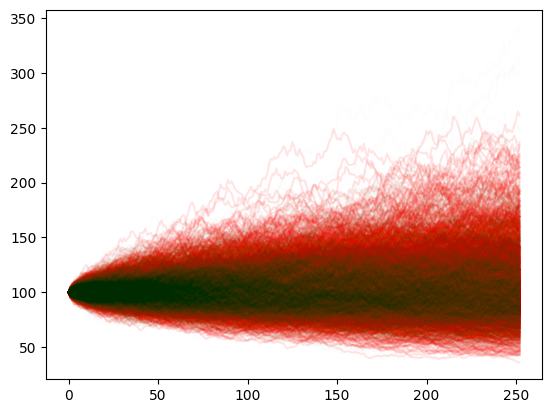

Mean price (expectation) at the end of the paths: 
 - under real world measure corrected to be risk-neutral: 106.9162 
 - under risk neutral measure: 106.2662


In [47]:

dw_P = np.random.normal(0, np.sqrt(dt), (n_paths, int(n_days * T)))
dw_Q = np.random.normal(0, np.sqrt(dt), (n_paths, int(n_days * T)))

S_P_corrected = np.zeros((n_paths, int(n_days * T) + 1))
S_P_corrected[:, 0] = s0
S_Q = np.zeros((n_paths, int(n_days * T) + 1))
S_Q[:, 0] = s0

for i in range(int(n_days * T)):
    # we adjust real world probabilities according to Girsanov's theorem 
    S_P_corrected[:, i+1] = S_P_corrected[:, i] * np.exp((mu - 0.5*sigma**2)*dt + sigma*(dw_P[:, i] - lambda_*dt))
    S_Q[:, i+1] = S_Q[:, i] * np.exp((r - 0.5*sigma**2)*dt + sigma*dw_Q[:, i])
    
plt.plot(S_P_corrected.T, color='red', alpha=0.1)
plt.plot(S_Q.T, color='green', alpha=0.01)
plt.show()

print(f'Mean price (expectation) at the end of the paths: \n - under real world measure corrected to be risk-neutral: {S_P_corrected[:, -1].mean():.4f} \n '
      f'- under risk neutral measure: {S_Q[:, -1].mean():.4f}')


In [48]:
# We can see that probabilities converged. They are different due to random variables sampling, probably increase of number of paths should make convergence stronger
prob_P_corrected_measure = sum(S_P_corrected[:, target_timestep] > target_price) / len(S_P_corrected[:, target_timestep])
prob_Q_measure = sum(S_Q[:, target_timestep] > target_price) / len(S_Q[:, target_timestep])

print(f'Probability that price of a stock is > {target_price} at {target_timestep} timestamp \n - under P measure: {prob_P_corrected_measure:.4f} '
      f'\n - under Q measure: {prob_Q_measure:.4f}')


Probability that price of a stock is > 120 at 170 timestamp 
 - under P measure: 0.2465 
 - under Q measure: 0.2400


Girsanov’s Theorem tells us exactly how the randomness itself changes when we switch worlds. It is the "engine" under the hood. It states that if you take a standard Brownian Motion $W_t^{\mathbb{P}}$ (which has no trend) and you view it from a Risk-Neutral perspective, it suddenly appears to have a drift (a trend) equal to the "Market Price of Risk" ($\lambda$): $W_t^{\mathbb{P}} = W_t^{\mathbb{Q}} - \lambda t$. This is a profound discovery. It means that the "uncertainty" in the real world is exactly the same as the "uncertainty" in the risk-neutral world; they just have different "baselines" or trends.

#### **The Radon-Nikodym Derivative**

The Radon-Nikodym Derivative provides the connection between the real-world and risk-neutral measures. It serves as the change of measure between $\mathbb{P}$ and $\mathbb{Q}$. In the recursive way the $Z_t$ is given by: $\Delta Z_t = exp(-\lambda \Delta W_t^{\mathbb{P}} - \frac{1}{2}\lambda^2 \Delta t)$. The process $Z_t$ adjusts for the difference in drifts between the real-world and risk-neutral measures. This derivative allows us to shift the probability measure while keeping the same Brownian motion. To transform a stock price in the discrete process from the real-world measure to the risk-neutral measure, we are focusing only on the drift adjustment. This transformation aligns the drift with the risk-free rate, effectively converting the process to behave according to the risk-neutral dynamics. 

When you multiply the real-world outcomes by these weights and take the average, the "extra" growth ($\mu$) is mathematically canceled out, leaving you with the risk-neutral expected value ($r$). Radon-Nikodym says: "The lines (paths under risk-neutral and real-world measure) don't have to match. Just multiply the final results by $Z_t$, and the average will be correct."


In [50]:
s0 = 100
mu = 0.2
r = 0.07
sigma = 0.3
T = 1.0
n_days = 252
dt = 1 / n_days
n_paths = 20000
lambda_ = (mu - r) / sigma

dw_P = np.random.normal(0, np.sqrt(dt), (n_paths, int(n_days * T)))
dw_Q = np.random.normal(0, np.sqrt(dt), (n_paths, int(n_days * T)))

S_P = np.zeros((n_paths, int(n_days * T) + 1))
S_P[:, 0] = s0
S_Q = np.zeros((n_paths, int(n_days * T) + 1))
S_Q[:, 0] = s0
Z = np.ones((n_paths, int(n_days * T) + 1))

for i in range(int(n_days * T)):
    S_P[:, i+1] = S_P[:, i] * np.exp((mu - 0.5*sigma**2)*dt + sigma*(dw_P[:, i]))  # price of S in real world measure
    S_Q[:, i+1] = S_Q[:, i] * np.exp((r - 0.5*sigma**2)*dt + sigma*dw_Q[:, i])  # price of S in risk-neutral measure
    Z[:, i+1] = Z[:, i] * np.exp(-lambda_ * dw_P[:, i] - 0.5 * (lambda_**2) * dt)
    
print(S_P[:, -1].mean())
print(S_Q[:, -1].mean())
print(np.mean(S_P[:, -1] * Z[:, -1]))
print(s0 * np.exp(r*T))



122.35696751169648
107.71289059896182
107.16849213020527
107.25081812542166
